In [1]:
import logging
from Generator import Generator
from VertexProperty import VertexProperty
import sys
import graph_tool.all as gt
from Rule import Rule, RHS, LHS
from networkx.algorithms.graph_hashing import weisfeiler_lehman_graph_hash
from bson import json_util
from bson.objectid import ObjectId
import argparse
from os import path
import json
import uuid
import networkx as nx
import shutil
from Metrics import MapLinearity, MissionLinearity,Leniency, PathRedundancy
import matplotlib.pyplot as plt
from os.path import isfile, join, isdir
from os import listdir, mkdir, remove
import pickle
import pandas as pd
import json

In [2]:
def SaveTrainingSet(samples, available):
    dir_path = "../data/trees/training-set-dormans/"
    if isdir(dir_path):
        shutil.rmtree(dir_path)
    if not isdir(dir_path):
        mkdir(dir_path)
    for sample_id in samples:
        if sample_id not in available:
            continue
        # this is really dumb we are reading a file just to dump it again
#         filename = "../data/generation-trees/" + grammar + "/" + sample_id + ".pkl"
        print("howdy")
        filename = "to-score-trees/" + sample_id + ".pkl"
        input_file = open(filename, "rb")
        tree = pickle.load(input_file)
        tree.saveTree(dir_path + sample_id + ".pkl")

In [3]:
def makeGraph(mongoGraph):
    g = gt.Graph()
    IDtoIndex = {}
    vertices = []
    g.vertex_properties["vertex_property"] = g.new_vertex_property("python::object")
    for i, node in enumerate(mongoGraph["nodes"]):
        v = g.add_vertex()
        IDtoIndex[node["id"]] = i
        abbrev = node["abbrev"]
        label = node["label"]
        terminality = False
        mark = node["mark"]

        vertices.append(v)
        g.vp.vertex_property[v] = VertexProperty(label, abbrev, terminality, mark)

    for edge in mongoGraph["edges"]:
        u = vertices[IDtoIndex[edge["from"]]]
        v = vertices[IDtoIndex[edge["to"]]]
        g.add_edge(u, v)
    return g


def makeGrammar(grammar):
    axiom = makeGraph(grammar["axiom"])
    # gt.graph_draw(axiom, vertex_text=abbrevs, output="img/axiom.png")

    rules = []
    for i, rule in enumerate(grammar["rules"]):
        rule_name = rule["name"]
        rule_lhs = rule["lhs"]
        lhs_graph = makeGraph(rule_lhs)
        lhs = LHS(lhs_graph)
        # gt.graph_draw(lhs_graph, vertex_text=lhs_abbrevs, output="lhs"+ str(i) +".png")
        rule_rhss = rule["rhs"]
        rhss = []
        for j, rule_rhs in enumerate(rule_rhss):
            rhs_graph = makeGraph(rule_rhs["graph"])
            rhs = RHS(rhs_graph, rule_rhs["probability"])
            rhss.append(rhs)
            # gt.graph_draw(
            #     rhs_graph, vertex_text=rhs_abbrevs, output="rhs-"  + str(i)+ "-" + str(j) + ".png"
            # )
        rules.append(Rule(rule_name, lhs, rhss, 1))

    return (axiom, rules)
safe_rooms = {"e", "g", "l", "lf", "lm", "n", "k", "kf", "km"}
non_critical_rooms = ["n", "l", "t"]

In [4]:
def hasMoreThanFour(graph):
    for v in graph.vertices():
        if len(graph.get_all_neighbors(v)) > 4:
            return True
    return False

In [5]:
def containsKM(graph):
    for v in graph.vertices():
        if graph.vp.vertex_property[v].abbrev == "km":
            return True
    return False

In [6]:
def findExit(graph):
    exit = 0
    for v in graph.vertices():
        if(graph.vp.vertex_property[v].abbrev == "g"):
            exit = v
            break
    return exit

In [7]:
def genExamples(gen, config):
    leniency = []
    map_linearity = []
    mission_linearity = []
    path_redundancy = []
    has_more_than_4 = []
    has_km= []
    sample_ids = []
    training_samples = []
    for i in range(1000):
        sample, sample_id = gen.applyRules(config)
        exit = findExit(sample)
        sample_ids.append(sample_id)
        has_more_than_4.append(hasMoreThanFour(sample))
        has_km.append(containsKM(sample))
        leni =  Leniency(sample,safe_rooms)
        mission_len =  MissionLinearity(sample,0,exit)
        path_redundancy =  PathRedundancy(sample,non_critical_rooms)
        leniency.append(leni)
        mission_linearity.append(mission_len)
        map_linearity.append(MapLinearity(sample))
    data = {"Sample ID": sample_ids, "Leniency": leniency, "Mission Linearity": mission_linearity, "Map Linearity": map_linearity, "Path Redundancy": path_redundancy , "More Than Four": has_more_than_4, "Has KM": has_km}
    df = pd.DataFrame(data)
    return df

In [8]:
def cleanDir(dir_path):
    if isdir(dir_path):
        shutil.rmtree(dir_path)

In [9]:
def SaveGraphs(samples, grammar):
    dir_path = "../data/sample-graphs/to-score/"
    if not isdir(dir_path):
        mkdir(dir_path)
    for sample_id in samples:
        # this is really dumb we are reading a file just to dump it again
#         filename = "../data/sample-graphs/" + grammar + "/" + sample_id + ".gt"
        filename = "../data/sample-graphs/" + grammar + "/" + sample_id 
        g = gt.load_graph(filename)
#         g.save(dir_path + sample_id + '.gt')
        g.save(dir_path + sample_id)

In [10]:
def drawExpRange(df, xlabel, ylabel, thresx,thresy,ax, axis = [False, False], col = 'r'):
    x = df[xlabel]
    y = df[ylabel]
    h = ax.hist2d(x,y, bins=[25,25], range=[[0,1],[0,1]])
#     ax.ylim([0,1])
    if axis[0]:
        ax.axvline(x=thresx, color= col)
    if axis[1]:
        ax.plot([thresy, thresy, thresy], color= col)
#     ax.xlim([0,1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
#     ax.colorbar()
    return h

In [11]:
def getAvail():
    directory = "to-score-trees/" 
    onlyfiles = [
        directory + f for f in listdir(directory) if isfile(join(directory, f))
    ]
    sample_ids = []
    for (i, filename) in enumerate(onlyfiles):
        gl = filename.split("/")
        cg = gl[1].split(".")
        sample_id = cg[0]
        sample_ids.append(sample_id)
    return sample_ids

In [12]:
df = pd.read_csv("Mission Graph Scoring.csv")
avail = getAvail()

In [13]:
temp = df.iloc[:,4:43] 
temp = temp.replace("Very Low",0)
temp = temp.replace("Low",1)
temp = temp.replace("Medium",2)
temp = temp.replace("High",3)
temp = temp.replace("Very High",4)
temp.shape
designer_1 = []
designer_2 = []
d1 = temp.iloc[0]
d2 = temp.iloc[1]
mn = 0
for i in range(0,39,3):
    string1 = "graph_"+str(mn)
    mn = mn + 1
    arr = []
    arr.append(d1[i])
    arr.append(d1[i+1])
    arr.append(d1[i+2])
    arr2 = []
    arr2.append(d2[i])
    arr2.append(d2[i+1])
    arr2.append(d2[i+2])
    designer_1.append(arr)
    designer_2.append(arr2)
#     print(string1)

In [14]:
designer_1_df = pd.DataFrame(designer_1, columns = ["Leniency", "Mission Linearity", "Path Redundancy"])
designer_1_df
designer_2_df = pd.DataFrame(designer_2, columns = ["Leniency", "Mission Linearity", "Path Redundancy"])

In [15]:
f = open("graphs.json", 'r')
data = json.load(f)

In [16]:
samples_id = []
for key in data:
    strin = data[key]["graph_id"]
    gl = strin.split("/")
    cg = gl[4].split('.')
    string = cg[0]
    samples_id.append(string)

In [17]:
designer_1_df["Samples ID"] = samples_id
designer_2_df["Samples ID"] = samples_id

In [18]:
training_samples = designer_2_df[designer_2_df["Leniency"] > 3]["Samples ID"]
len(training_samples)

2

In [19]:
SaveTrainingSet(training_samples, avail)

howdy
howdy


In [20]:
with open("../data/grammars/dormans-grammar.json") as json_file:
    data = json.load(json_file)

axiom, rules = makeGrammar(data)
config = {"max_applications": 30, "sampling_method": "uniform"}
gen = Generator(axiom, rules, "dormans-grammar-3")
# alt_df = genExamples(gen,config)

In [21]:
config = {"max_applications": 30, "sampling_method": "grammar"}
gen_altered = Generator(axiom, rules, "dormans-grammar-altered")
sample, sample_id = gen.applyRules(config)
gen_altered.learnParameters("../data/trees/training-set-dormans/")

cleanDir("../data/sample-graphs/dormans-grammar-altered")
trained_df1 = genExamples(gen_altered,config)


In [22]:
training_samples = designer_2_df[designer_2_df["Path Redundancy"] > 3]["Samples ID"]
len(training_samples)
SaveTrainingSet(training_samples, avail)

howdy
howdy
howdy
howdy


In [23]:
config = {"max_applications": 30, "sampling_method": "grammar"}
gen_altered = Generator(axiom, rules, "dormans-grammar-altered")
sample, sample_id = gen.applyRules(config)
gen_altered.learnParameters("../data/trees/training-set-dormans/")

cleanDir("../data/sample-graphs/dormans-grammar-altered")
trained_df2 = genExamples(gen_altered,config)

In [24]:
training_samples = designer_2_df[designer_2_df["Mission Linearity"] > 2]["Samples ID"]
len(training_samples)
SaveTrainingSet(training_samples, avail)

howdy


In [25]:
config = {"max_applications": 30, "sampling_method": "grammar"}
gen_altered = Generator(axiom, rules, "dormans-grammar-altered")
sample, sample_id = gen.applyRules(config)
gen_altered.learnParameters("../data/trees/training-set-dormans/")

cleanDir("../data/sample-graphs/dormans-grammar-altered")
trained_df3 = genExamples(gen_altered,config)

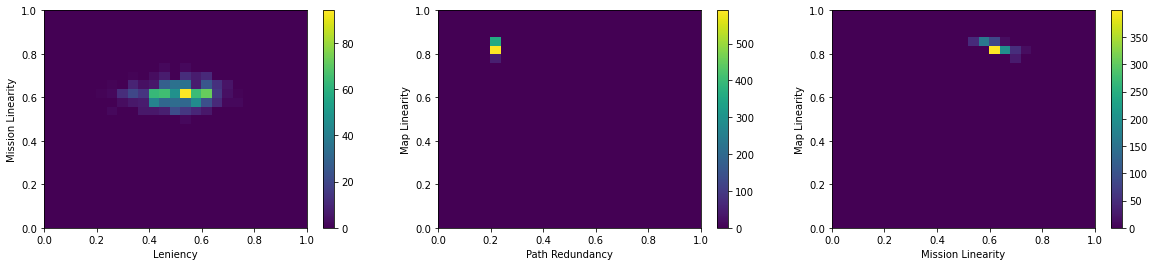

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
# fig = drawExpRange(df, 'Leniency', 'Mission Linearity',thres1, thres2,ax1 [False, False])
h1 = drawExpRange(trained_df1, 'Leniency', 'Mission Linearity',0, 0,ax1, [False, False], 'w')
plt.colorbar(h1[3],ax=ax1)
h2 = drawExpRange(trained_df2, 'Path Redundancy', 'Map Linearity',0, 0,ax2, [False, False], 'w')
plt.colorbar(h2[3],ax=ax2)
h3 = drawExpRange(trained_df3, 'Mission Linearity', 'Map Linearity',0, 0,ax3, [False, False], 'w')
plt.colorbar(h3[3],ax=ax3)
plt.savefig("designer-2.png")